In [1]:
import sys
import numpy as np
from spectres import spectres
from matplotlib import pyplot as plt
from astropy.io import fits
sys.path.append('aspired')

import aspired

aspired/aspired.py:270: UserWarning: No bias frames. Bias subtraction is not performed.
  warnings.warn('No bias frames. Bias subtraction is not performed.')
aspired/aspired.py:280: UserWarning: No flat frames. Field-flattening is not performed.
  warnings.warn('No flat frames. Field-flattening is not performed.')
aspired/aspired.py:311: RuntimeWarning: invalid value encountered in log10
  np.log10(self.light_master),


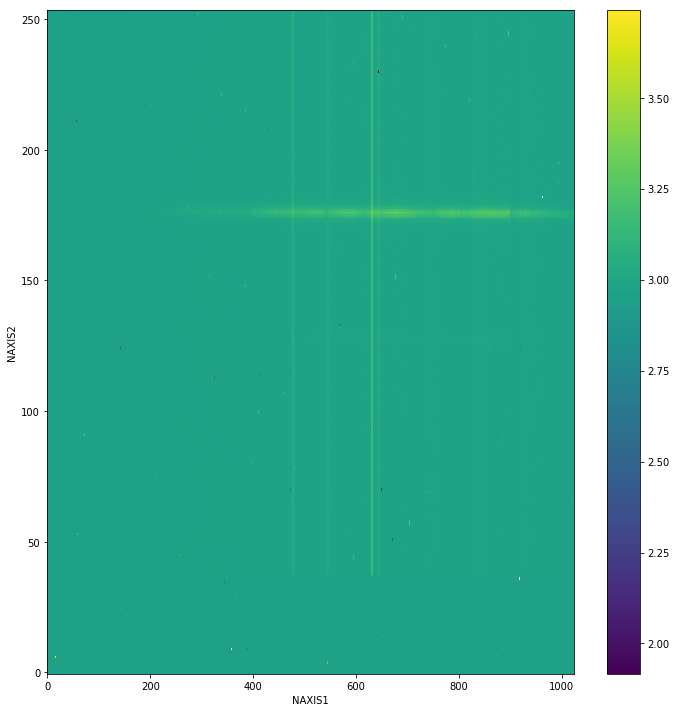

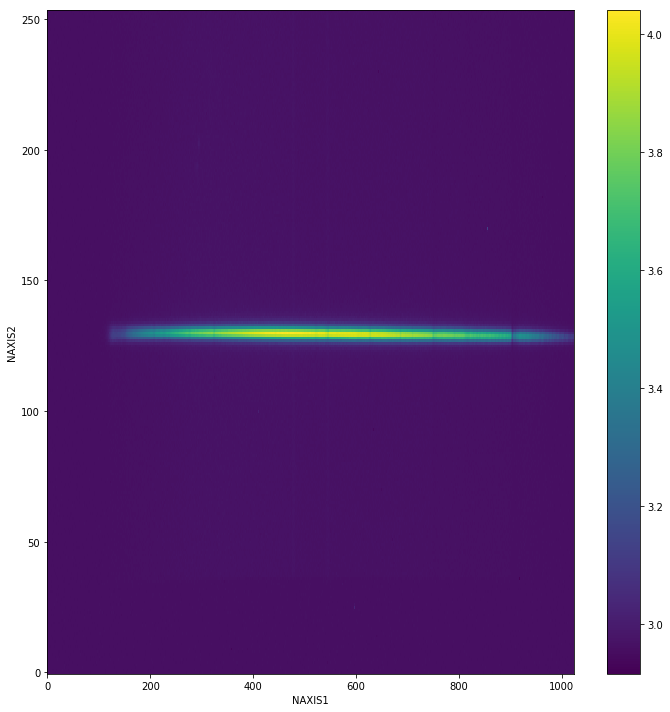

In [2]:
science_frame = aspired.ImageReduction('examples/lhs6328.list')
science_frame.reduce()
science_frame.inspect()
science_frame.savefits(overwrite=True)

standard_frame = aspired.ImageReduction('examples/hiltner102.list')
standard_frame.reduce()
standard_frame.inspect()

In [20]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe"

fig = go.Figure(
    data=go.Heatmap(z=np.log10(science_frame.fits_data.data), colorscale="Viridis")
)
fig.show()


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in log10



In [3]:
# Example data from SPRAT
# LHS6328 companion WD
science_data = science_frame.fits_data.data

# Example data from SPRAT
# Hiltner102
standard_data = standard_frame.fits_data.data

In [6]:
# Set the spectral and spatial direction
Saxis = 1
Waxis = 0

# spec mask
spec_mask = np.arange(110,science_frame.fits_data.header['NAXIS1'])
spatial_mask = np.arange(40,science_frame.fits_data.header['NAXIS2'])

# initialise the two aspired.TwoDSpec()
lhs6328 = aspired.TwoDSpec(science_data, spatial_mask=spatial_mask, spec_mask=spec_mask, rn=10., cr=False, gain=1., seeing=1.2, display=True)
hilt102 = aspired.TwoDSpec(standard_data, spatial_mask=spatial_mask, spec_mask=spec_mask, rn=10., cr=False, gain=1., seeing=1.2, display=True)

Tracing Aperture using nsteps=20
Step 1 of 20 of spectrum 1 of 1 has a poor fit. Initial guess is used instead.
Spectrum 1 : Trace gaussian width = [0.         1.33487738 1.43755273 1.5637606  1.47652352 1.46942854
 1.45532483 1.44448173 1.4403427  1.41007892 1.39143082 1.39458666
 1.38732844 1.38332202 1.38041924 1.38116738 1.38209503 1.30979899
 1.22423162 0.        ] pixels


aspired/aspired.py:668: RuntimeWarning: invalid value encountered in log10
  np.log10(self.img),


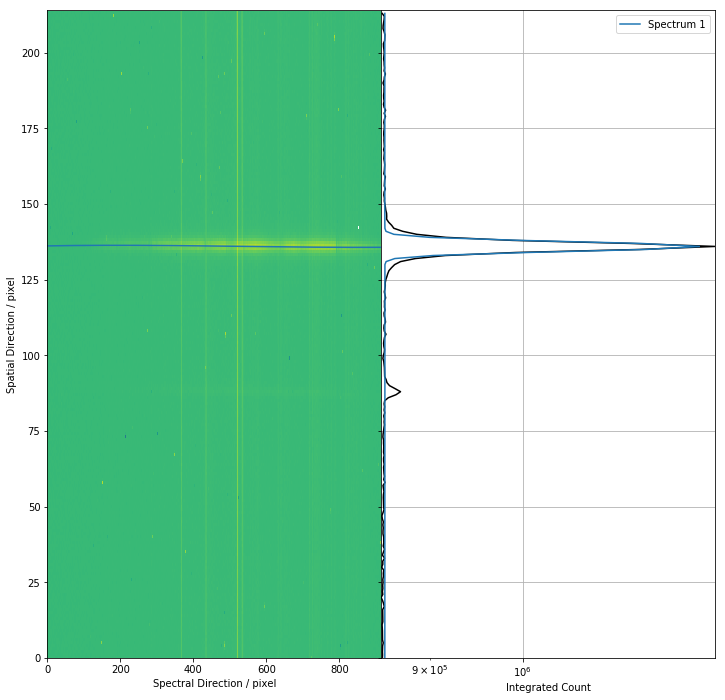

Tracing Aperture using nsteps=20
Spectrum 1 : Trace gaussian width = [1.93159047 1.52726052 1.33156853 1.2467093  1.20966329 1.19195674
 1.18020769 1.17620279 1.17356629 1.18092045 1.18774782 1.19724846
 1.21096364 1.22869804 1.24867704 1.27033097 1.30259428 1.38472734
 1.36437691 0.        ] pixels


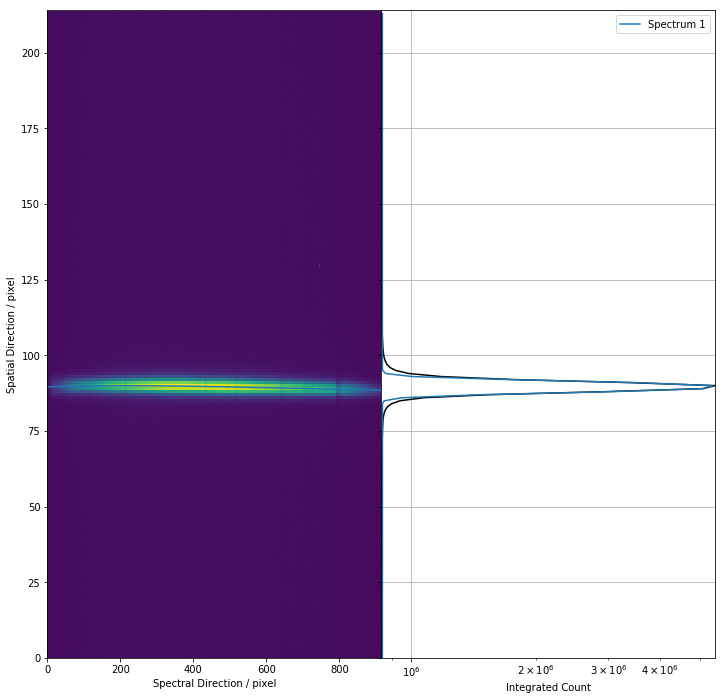

In [7]:
# automatically trace the spectrum
lhs6328.ap_trace(nsteps=20, recenter=False, prevtrace=(0, ), fittype='spline', bigbox=8)
hilt102.ap_trace(nsteps=20, recenter=False, prevtrace=(0, ), fittype='spline', bigbox=8)

aspired/aspired.py:1011: RuntimeWarning: invalid value encountered in log10
  min(median_trace+widthup+skysep+skywidth, len(self.img[0])), :]),


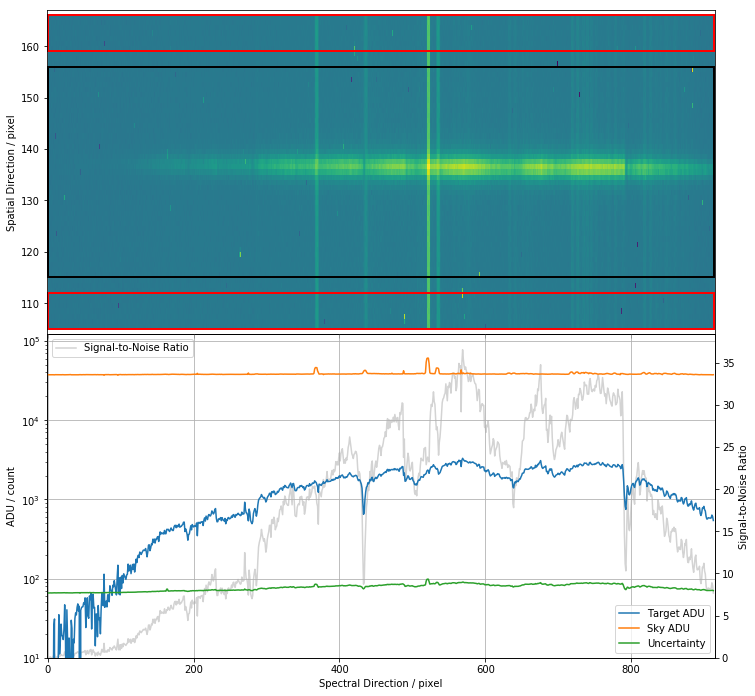

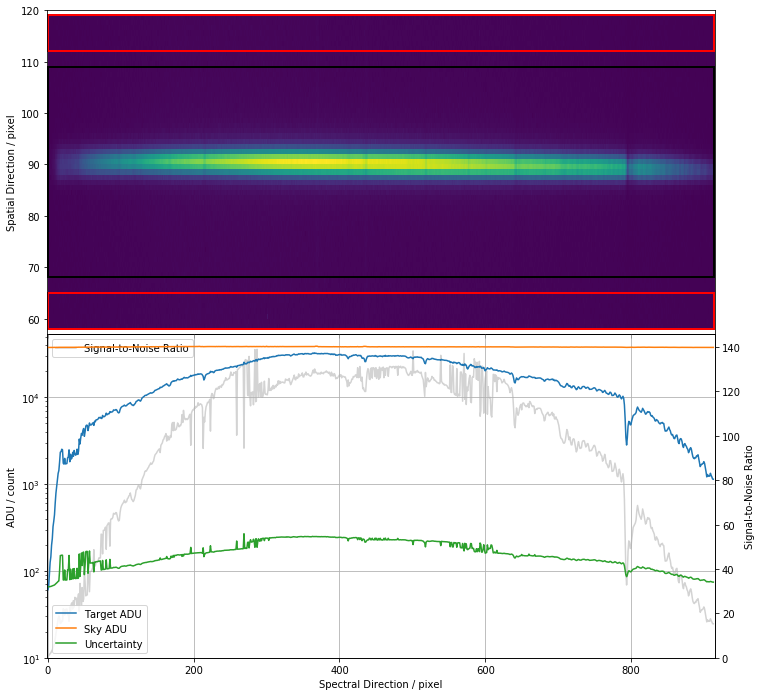

In [8]:
# Optimal extracting spectrum by summing over the aperture along the trace
lhs6328.ap_extract(apwidth=20)
hilt102.ap_extract(apwidth=20)

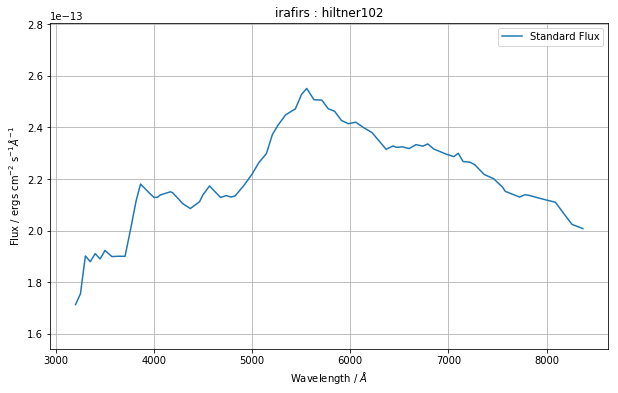

In [9]:
fluxcal = aspired.StandardFlux(target='hiltner102', group='irafirs', cutoff=0.4, ftype='flux')
fluxcal.load_standard()
fluxcal.inspect_standard()

In [10]:
# Placeholder of wavelength calibration
wavecal = type('', (), {})()
wavecal.pfit_type = 'poly'
wavecal.pfit = [3.17707768e-07, -6.15874242e-04,  5.13807283e+00,  3.22724313e+03]


/Users/marcolam/git/SpectRes/spectres/spectral_resampling.py:74: UserWarning: spectres: Part of the new wavelengths specified is outside the range of the input data, they are filled with zeros.
  warnings.warn("spectres: Part of the new wavelengths specified is "
aspired/aspired.py:1455: RuntimeWarning: divide by zero encountered in true_divide
  sensitivity = flux_std_true / flux_std


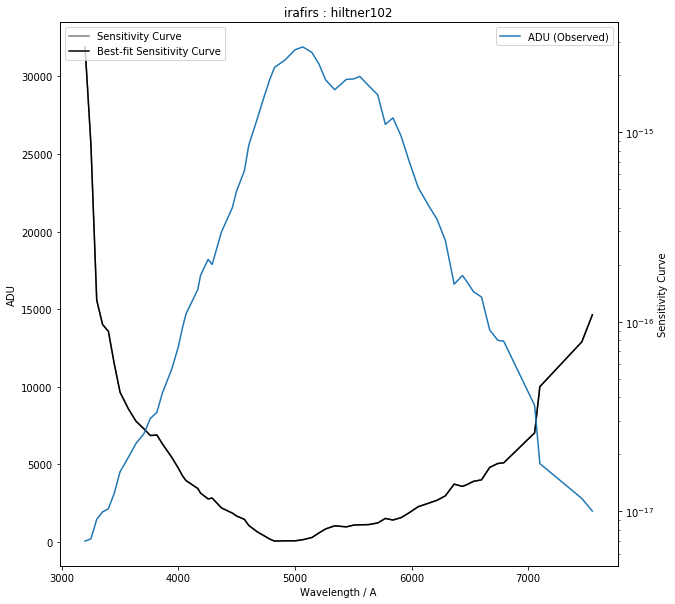

In [11]:
# Get the sensitivity curves
lhs6328_reduced = aspired.OneDSpec(lhs6328, wavecal, standard=hilt102, wave_cal_std=wavecal, flux_cal=fluxcal)
lhs6328_reduced.apply_wavelength_calibration('all')
lhs6328_reduced.compute_sencurve(kind='cubic')
lhs6328_reduced.inspect_sencurve()

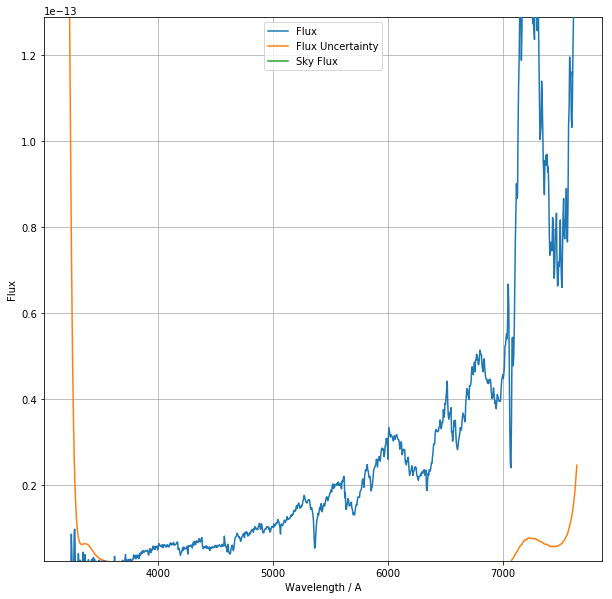

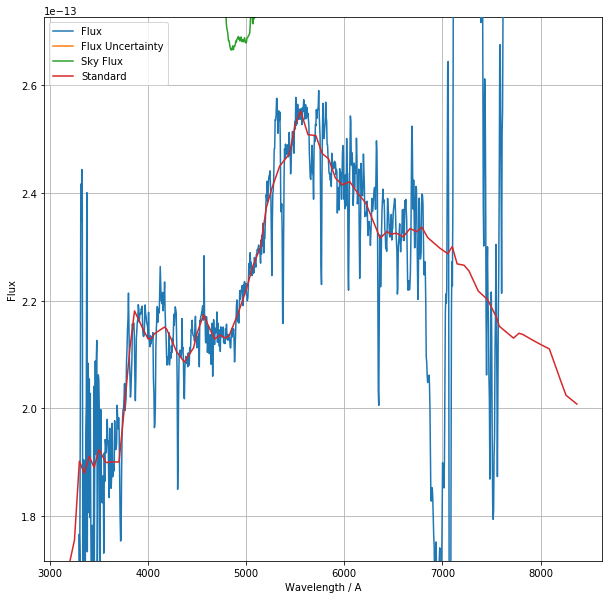

In [12]:
lhs6328_reduced.apply_flux_calibration('all')
lhs6328_reduced.inspect_reduced_spectrum('all')

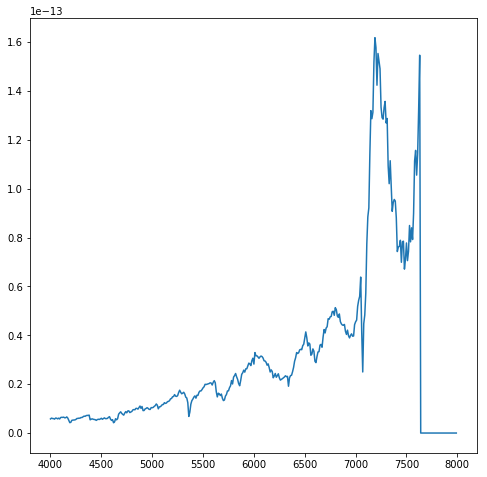

In [13]:
wave_lhs6328, flux_lhs6328 = lhs6328_reduced.wave, lhs6328_reduced.flux
wave = np.arange(4000.,8000.,10.)
flux = spectres(wave, wave_lhs6328, flux_lhs6328)
plt.figure(figsize=(8,8))
plt.plot(wave, flux)